In [ ]:
from matplotlib import pyplot as plt
from nilearn.signal import clean
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cross_decomposition import PLSCanonical
from sklearn.decomposition import PCA
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

In [ ]:
# Initialize
PATH = '...'

Define functions

In [ ]:
def matrix_cross_corr(a, b):
    c = np.zeros((np.shape(a)[1], np.shape(b)[1]))
    for i in range(np.shape(a)[1]):
        for j in range(np.shape(b)[1]):
            c[i, j] = np.corrcoef(a[:, i], b[:, j])[0, 1]
    return c

In [ ]:
def get_ci(x):
    x_mean = np.mean(x)
    low = np.percentile(x, 2.5, axis=0)
    high = np.percentile(x, 97.5, axis=0)
    if x_mean > 0:
        low = x_mean - low
        high = high - x_mean
    else:
        low = low - x_mean
        high = x_mean - high
    ci = np.abs(np.array([low, high]).reshape(-1,1))
    return ci

Load data

In [ ]:
# Load genetic data
df_cnv = pd.read_csv(PATH + '....csv', low_memory=False)
df_cnv = df_cnv[df_cnv['TYPE'].isin(['DEL', 'DUP', 'CTRL', 'BOTH'])]
idx_cnv = df_cnv[df_cnv['TYPE'].isin(['DEL', 'DUP', 'BOTH'])].SampleID.values
df_cnv.set_index('SampleID', inplace=True)
# Genetic covariates
df_cnv = df_cnv.loc[:, ['TYPE', 'sum_loeuf', 'n_genes', 'gene_id']]

# Load clean data
df_brain = pd.read_csv(PATH + '....csv', index_col=0)
df_phens = pd.read_csv(PATH + '....csv', index_col=0)
df_cov = pd.read_csv(PATH + '....csv', index_col=0)

In [ ]:
idx_str = df_brain.index
idx_phens = df_phens.index
idx_genetic = df_cnv.index
idx_cov = df_cov.index

idx_all = list(set(idx_str) & set(idx_phens) & set(idx_genetic) & set(idx_cov))
idx_cnv = np.intersect1d(idx_cnv, idx_all)
idx_ctrl = np.setdiff1d(idx_all, idx_cnv)

In [ ]:
# Generate relationship matrix
relationship_matrix = pd.read_csv(PATH + '.../king.kin0', sep='\t')

df_group = pd.DataFrame(data=np.arange(0, len(idx_all)), columns=['Group'], index=idx_all)
for i in range(np.shape(relationship_matrix)[0]):
    id1 = relationship_matrix.iloc[i, 1]
    id2 = relationship_matrix.iloc[i, 3]
    # Check if both IDs are in the index
    if id1 in idx_all and id2 in idx_all:
        # Check if both IDs have the same group ID
        if df_group.loc[id1, 'Group'] != df_group.loc[id2, 'Group']:
            # Assign the same group ID to both IDs
            group_id = df_group.loc[id1, 'Group']
            df_group.loc[df_group['Group'] == group_id, 'Group'] = df_group.loc[id2, 'Group']

Prepare data

In [ ]:
df_cnv = df_cnv.loc[idx_all, :]
df_brain = df_brain.loc[idx_all, :]
df_phens = df_phens.loc[idx_all, :]
df_cov = df_cov.loc[idx_all, :]

In [ ]:
df_phens[:] = clean(df_brain.values,
                    confounds=df_cov.loc[:, ['interview_age', 'sex', 'volume', 'scanner']].values,
                    detrend=False, standardize=False)
df_phens[:] = clean(df_phens.values,
                    confounds=df_cov.loc[:, ['interview_age', 'sex']].values,
                    detrend=False, standardize=False)

In [ ]:
# Prepare data
x_ctrl = df_phens.values.astype('float')[df_cnv['TYPE'] == 'CTRL']
y_ctrl = df_phens.values.astype('float')[df_cnv['TYPE'] == 'CTRL']

x_del = df_phens.values.astype('float')[df_cnv['TYPE'].isin(['DEL', 'BOTH'])]
y_del = df_phens.values.astype('float')[df_cnv['TYPE'].isin(['DEL', 'BOTH'])]

x_dup = df_phens.values.astype('float')[df_cnv['TYPE'].isin(['DUP', 'BOTH'])]
y_dup = df_phens.values.astype('float')[df_cnv['TYPE'].isin(['DUP', 'BOTH'])]

Full dataset mean

In [ ]:
# Cross validation of permuted PLS components
pls_dim = 3
pca_dim = 50
n_iter = 1000

pls_orig = PLSCanonical(n_components=pls_dim, scale=False,
                        max_iter=10000, tol=1e-5)
pca_x = PCA(n_components=pca_dim)
pca_y = PCA(n_components=pca_dim)

scaler = StandardScaler()

id_group = df_group.loc[df_cnv['TYPE'] == 'CTRL', 'Group'].values

# Z-score data
x_ctrl_ss = scaler.fit_transform(x_ctrl)  # fit_transform for x_ctrl
x_del_ss = scaler.transform(x_del)  # transform for x_del
x_dup_ss = scaler.transform(x_dup)  # transform for x_dup
y_ctrl_ss = scaler.fit_transform(y_ctrl)  # fit_transform for y_ctrl
y_del_ss = scaler.transform(y_del)  # transform for y_del
y_dup_ss = scaler.transform(y_dup)  # transform for y_dup

# Reduce data with PCA
x_ctrl_ss_pca = pca_x.fit_transform(x_ctrl_ss)
y_ctrl_ss_pca = pca_y.fit_transform(y_ctrl_ss)

# Fit PLS model
pls_orig.fit(x_ctrl_ss_pca, y_ctrl_ss_pca)

# Paramenters of PLS
x_rotations = pls_orig.x_rotations_
y_rotations = pls_orig.y_rotations_

# Invese transform data
x_rotations = pca_x.inverse_transform(x_rotations.T).T
y_rotations = pca_y.inverse_transform(y_rotations.T).T

# Project control data
x_ctrl_score = np.dot(x_ctrl_ss, x_rotations)
y_ctrl_score = np.dot(y_ctrl_ss, y_rotations)

# Project CNV data using PLS based on control data
score_x_del_mean = np.mean(np.dot(x_del_ss, x_rotations), axis=0)
score_y_del_mean = np.mean(np.dot(y_del_ss, y_rotations), axis=0)

score_x_dup_mean = np.mean(np.dot(x_dup_ss, x_rotations), axis=0)
score_y_dup_mean = np.mean(np.dot(y_dup_ss, y_rotations), axis=0)

Calculate differences in projections

In [ ]:
x1_score_test_mean = []
y1_score_test_mean = []
x2_score_mean = []
y2_score_mean = []

x1 = np.array(x_ctrl)
y1 = np.array(y_ctrl)
x2 = np.array(x_dup)
y2 = np.array(y_dup)

err_order_repeat_x = 0
err_order_repeat_y = 0
err_order_mismath = 0
err_low_x = 0
err_low_y = 0
it = 0
while len(x1_score_test_mean) < n_iter:
    it = it + 1 
    pls = PLSCanonical(n_components=pls_dim+2, scale=False,
                       max_iter=1000, tol=1e-5)
    pca_x = PCA(n_components=pca_dim)
    pca_y = PCA(n_components=pca_dim)
    scaler = StandardScaler()

    x_rotations_orig = pls_orig.x_rotations_
    y_rotations_orig = pls_orig.y_rotations_
    
    # Define the GroupShuffleSplit object
    gss = GroupShuffleSplit(test_size=0.1, n_splits=10, random_state=it)
    # Split the data while respecting group IDs
    x1_score_test_means = []
    y1_score_test_means = []
    x2_score_means = []
    y2_score_means = []
    for train_idx, test_idx in gss.split(x1, y1, groups=id_group):
        x1_train, x1_test = x1[train_idx], x1[test_idx]
        y1_train, y1_test = y1[train_idx], y1[test_idx]
    
        # Z-score data
        x1_train_ss = scaler.fit_transform(x1_train)
        x1_test_ss = scaler.transform(x1_test)
        x2_ss = scaler.transform(x2)

        y1_train_ss = scaler.fit_transform(y1_train)
        y1_test_ss = scaler.transform(y1_test)
        y2_ss = scaler.transform(y2)

        # Reduce data with PCA
        x1_train_ss_pca = pca_x.fit_transform(x1_train_ss)
        y1_train_ss_pca = pca_y.fit_transform(y1_train_ss)

        # Fit PLS model
        pls.fit(x1_train_ss_pca, y1_train_ss_pca)

        # Paramenters of PLS
        x1_train_rotations = pls.x_rotations_
        y1_train_rotations = pls.y_rotations_

        # Invese transform data
        x1_train_rotations = pca_x.inverse_transform(x1_train_rotations.T).T
        y1_train_rotations = pca_y.inverse_transform(y1_train_rotations.T).T

        # Project test data
        x1_score_test = np.dot(x1_test_ss, x1_train_rotations)
        y1_score_test = np.dot(y1_test_ss, y1_train_rotations)

        # Project CNV data
        x2_score = np.dot(x2_ss, x1_train_rotations)
        y2_score = np.dot(y2_ss, y1_train_rotations)

        # Append mean values
        x1_score_test_means.append(np.mean(x1_score_test, axis=0))
        y1_score_test_means.append(np.mean(y1_score_test, axis=0))

        x2_score_means.append(np.mean(x2_score, axis=0))
        y2_score_means.append(np.mean(y2_score, axis=0))

    x1_score_test_mean.append(np.mean(x1_score_test_means, axis=0))
    y1_score_test_mean.append(np.mean(y1_score_test_means, axis=0))

    x2_score_mean.append(np.mean(x2_score_means, axis=0))
    y2_score_mean.append(np.mean(y2_score_means, axis=0))

x1_score_test_mean = np.array(x1_score_test_mean)
y1_score_test_mean = np.array(y1_score_test_mean)
x2_score_mean = np.array(x2_score_mean)
y2_score_mean = np.array(y2_score_mean)

In [ ]:
score_x_ctrl_test = x1_score_test_mean
score_y_ctrl_test = y1_score_test_mean

score_x_del = x2_score_mean
score_y_del = y2_score_mean

score_x_dup = x2_score_mean
score_y_dup = y2_score_mean

Barplot CNVs scores

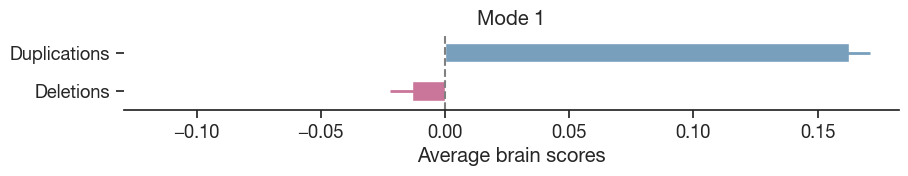

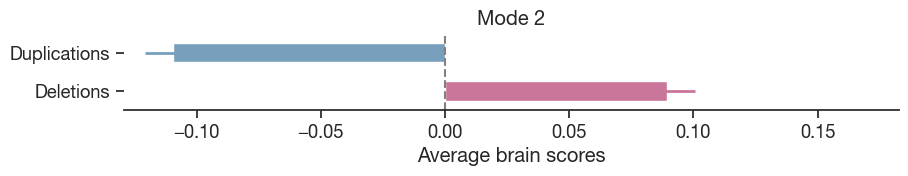

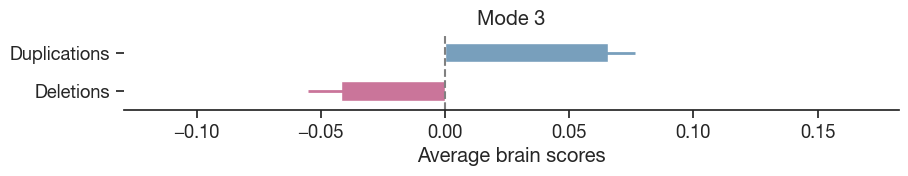

In [ ]:
# Plot x scores
for i in range(pls_dim):
    sns.set_theme(style="ticks", palette="colorblind", font_scale=1.2,
                  font='Helvetica Neue', rc={"axes.spines.right": False,
                                             "axes.spines.top": False,
                                             "axes.spines.left": False})
    fig, ax = plt.subplots(1, figsize=(10, 1))
    ci_del = get_ci(score_x_del[:, i])
    g_del = ax.barh(0, score_x_del_mean[i], height=0.5, label='Deletions')
    plt.errorbar(score_x_del_mean[i], 0, xerr=ci_del,
                 capsize=0, capthick=2, elinewidth=2)

    ci_dup = get_ci(score_x_dup[:, i])
    g_dup = ax.barh(1, score_x_dup_mean[i], height=0.5, label='Duplications')
    plt.errorbar(score_x_dup_mean[i], 1, xerr=ci_dup,
                 capsize=0, capthick=2, elinewidth=2)

    ax.set_title('Mode ' + str(i+1))
    ax.set_xlabel('Average brain scores')
    ax.set_ylabel('')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Deletions', 'Duplications'])
    ax.set_xlim([np.min([score_x_del_mean, score_x_dup_mean])-0.02,
                 np.max([score_x_del_mean, score_x_dup_mean])+0.02])
    ax.set_ylim([-0.5, 1.5])
    plt.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], colors='grey', linestyles='dashed')
    plt.show()

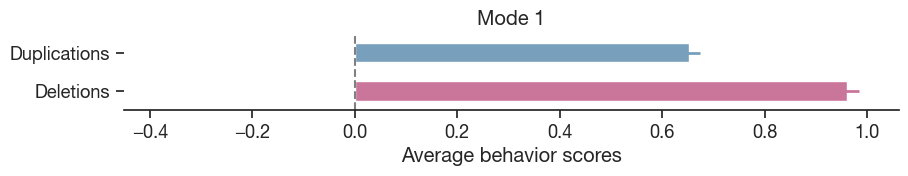

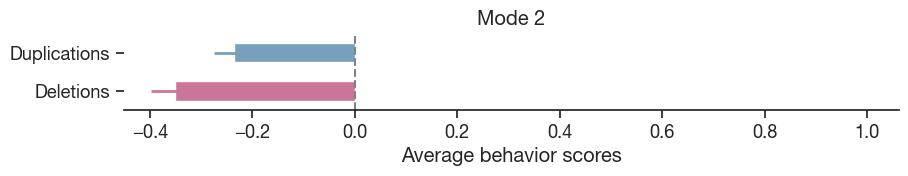

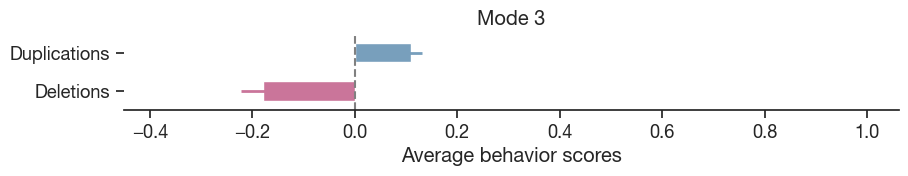

In [ ]:
# Behavior scores
for i in range(3):
    sns.set_theme(style="ticks", palette="colorblind", font_scale=1.2,
                  font='Helvetica Neue', rc={"axes.spines.right": False,
                                             "axes.spines.top": False,
                                             "axes.spines.left": False})
    fig, ax = plt.subplots(1, figsize=(10, 1))
    ci_del = get_ci(score_y_del[:, i])
    g_del = ax.barh(0, score_y_del_mean[i], height=0.5, label='Deletions')
    plt.errorbar(score_y_del_mean[i], 0, xerr=ci_del,
                 capsize=0, capthick=2, elinewidth=2)

    ci_dup = get_ci(score_y_dup[:, i])
    g_dup = ax.barh(1, score_y_dup_mean[i], height=0.5,label='Duplications')
    plt.errorbar(score_y_dup_mean[i], 1, xerr=ci_dup,
                 capsize=0, capthick=2, elinewidth=2)

    ax.set_title('Mode ' + str(i+1))
    ax.set_xlabel('Average behavior scores')
    ax.set_ylabel('')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Deletions', 'Duplications'])
    ax.set_xlim([np.min([score_y_del_mean, score_y_dup_mean])-0.1,
                 np.max([score_y_del_mean, score_y_dup_mean])+0.1])
    ax.set_ylim([-0.5, 1.5])
    plt.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], colors='grey', linestyles='dashed')
    plt.show()